In [4]:
import os, json, time, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [5]:
import os
print(os.listdir("."))  # –ø–æ–∫–∞–∂–µ—Ç –≤—Å–µ —Ñ–∞–π–ª—ã —Ä—è–¥–æ–º —Å –Ω–æ—É—Ç–±—É–∫–æ–º


['yoga_TRAIN', 'Wine_TEST', 'yoga_TEST', '–î–æ–π–∫–æ–≤_–ª–∞–±–æ—Ä–∞—Ç–æ—Ä–Ω–∞—è_1_–≤—Ä–µ–º–µ–Ω–Ω—ã–µ_—Ä—è–¥—ã.ipynb', 'Wine_TRAIN']


In [18]:
import os

base_dir = "."  # —Ç–µ–∫—É—â–∞—è –ø–∞–ø–∫–∞, –≥–¥–µ –ª–µ–∂–∏—Ç –Ω–æ—É—Ç–±—É–∫ –∏ —Ñ–∞–π–ª—ã

datasets = [
    ("Wine", os.path.join(base_dir, "Wine_TRAIN"), os.path.join(base_dir, "Wine_TEST")),
    ("Yoga", os.path.join(base_dir, "yoga_TRAIN"), os.path.join(base_dir, "yoga_TEST"))
]


In [19]:
# –§–æ—Ä–º–∞—Ç UCR: –≤ –ø–µ—Ä–≤–æ–π –∫–æ–ª–æ–Ω–∫–µ ‚Äî –∫–ª–∞—Å—Å (—Ü–µ–ª–æ–µ), –¥–∞–ª–µ–µ —Ä–∞–≤–Ω–æ–π –¥–ª–∏–Ω—ã —Ç–æ—á–∫–∏ —Ä—è–¥–∞ (float).
data_cache = {}

for name, train_path, test_path in datasets:
    # –ü—ã—Ç–∞–µ–º—Å—è –∑–∞–≥—Ä—É–∑–∏—Ç—å —á–µ—Ä–µ–∑ numpy (whitespace). –ù—É –∏–ª–∏ —á–µ—Ä–µ–∑ pandas —Å –≥–∏–±–∫–∏–º sep
    try:
        arr_tr = np.loadtxt(train_path)
    except Exception:
        df_tr = pd.read_csv(train_path, header=None, sep=r"\s+|,|;|\t", engine="python")
        arr_tr = df_tr.values

    try:
        arr_te = np.loadtxt(test_path)
    except Exception:
        df_te = pd.read_csv(test_path, header=None, sep=r"\s+|,|;|\t", engine="python")
        arr_te = df_te.values

    if arr_tr.ndim == 1: arr_tr = arr_tr.reshape(1, -1)
    if arr_te.ndim == 1: arr_te = arr_te.reshape(1, -1)

    y_tr = arr_tr[:, 0].astype(int)
    X_tr = arr_tr[:, 1:].astype(float)

    y_te = arr_te[:, 0].astype(int)
    X_te = arr_te[:, 1:].astype(float)

    print(f"{name}: TRAIN shape = {X_tr.shape}, TEST shape = {X_te.shape}, classes(train) = {np.unique(y_tr)}")
    data_cache[name] = (X_tr, y_tr, X_te, y_te)


Wine: TRAIN shape = (57, 234), TEST shape = (54, 234), classes(train) = [1 2]
Yoga: TRAIN shape = (300, 426), TEST shape = (3000, 426), classes(train) = [1 2]


In [22]:
# –°–ª–æ–≤–∞—Ä—å –¥–ª—è –Ω–æ—Ä–º–∞–ª–∏–∑–æ–≤–∞–Ω–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö
normed_sets = {}

# –ü—Ä–æ–±–µ–≥–∞–µ–º –ø–æ –≤—Å–µ–º –Ω–∞–±–æ—Ä–∞–º
for ds_name, (Xtr, ytr, Xte, yte) in data_cache.items():
    # —Å–æ–∑–¥–∞—ë–º –º–∞—Ç—Ä–∏—Ü—ã –ø–æ–¥ –Ω–æ—Ä–º–∞–ª–∏–∑–æ–≤–∞–Ω–Ω—ã–µ —Ä—è–¥—ã
    Xtr_norm = np.zeros_like(Xtr, dtype=float)
    Xte_norm = np.zeros_like(Xte, dtype=float)

    # –Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—è TRAIN
    for i, seq in enumerate(Xtr):
        m, s = seq.mean(), seq.std()
        Xtr_norm[i] = (seq - m) / s if s != 0 else np.zeros_like(seq)

    # –Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—è TEST
    for i, seq in enumerate(Xte):
        m, s = seq.mean(), seq.std()
        Xte_norm[i] = (seq - m) / s if s != 0 else np.zeros_like(seq)

    # —Å–æ—Ö—Ä–∞–Ω–∏–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç
    normed_sets[ds_name] = (Xtr_norm, ytr, Xte_norm, yte)

    print(f"{ds_name}: –Ω–æ—Ä–º–∏—Ä–æ–≤–∫–∞ –∑–∞–≤–µ—Ä—à–µ–Ω–∞ | train mean={Xtr_norm.mean():.2f}, std={Xtr_norm.std():.2f}")


Wine: –Ω–æ—Ä–º–∏—Ä–æ–≤–∫–∞ –∑–∞–≤–µ—Ä—à–µ–Ω–∞ | train mean=-0.00, std=1.00
Yoga: –Ω–æ—Ä–º–∏—Ä–æ–≤–∫–∞ –∑–∞–≤–µ—Ä—à–µ–Ω–∞ | train mean=0.00, std=1.00


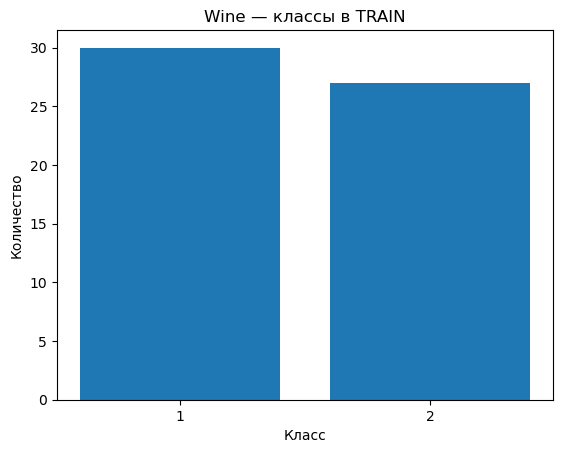

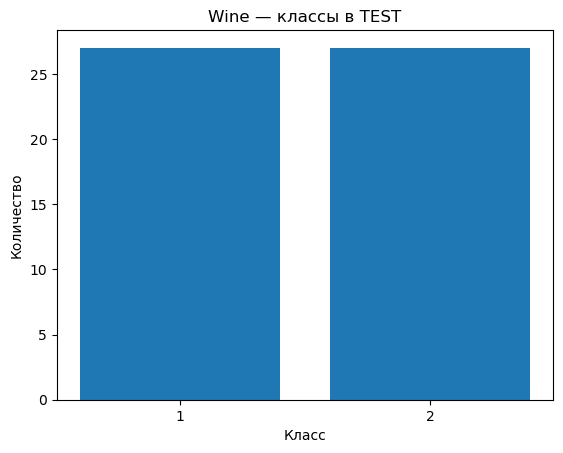

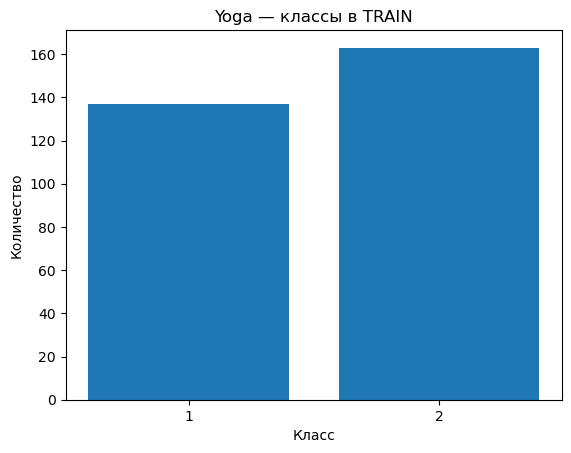

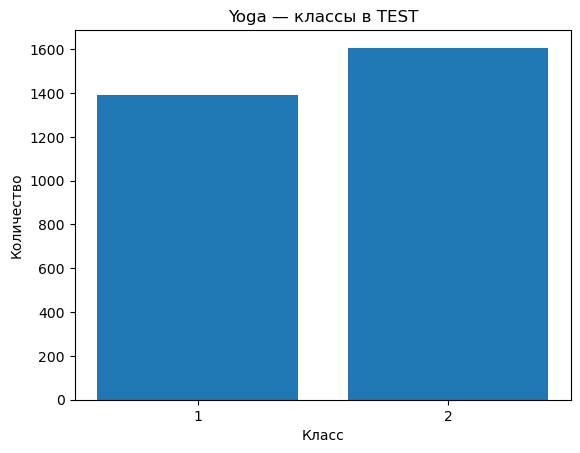

In [23]:
# –ü–æ—Å–º–æ—Ç—Ä–∏–º, –∫–∞–∫ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª—è—é—Ç—Å—è –æ–±—ä–µ–∫—Ç—ã –ø–æ –∫–ª–∞—Å—Å–∞–º –≤ train/test
for ds_name, (Xtr, ytr, Xte, yte) in data_cache.items():
    # TRAIN
    uniq, counts = np.unique(ytr, return_counts=True)
    plt.figure()
    plt.bar(uniq.astype(str), counts)
    plt.title(f"{ds_name} ‚Äî –∫–ª–∞—Å—Å—ã –≤ TRAIN")
    plt.xlabel("–ö–ª–∞—Å—Å"); plt.ylabel("–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ")
    plt.show()

    # TEST
    uniq, counts = np.unique(yte, return_counts=True)
    plt.figure()
    plt.bar(uniq.astype(str), counts)
    plt.title(f"{ds_name} ‚Äî –∫–ª–∞—Å—Å—ã –≤ TEST")
    plt.xlabel("–ö–ª–∞—Å—Å"); plt.ylabel("–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ")
    plt.show()


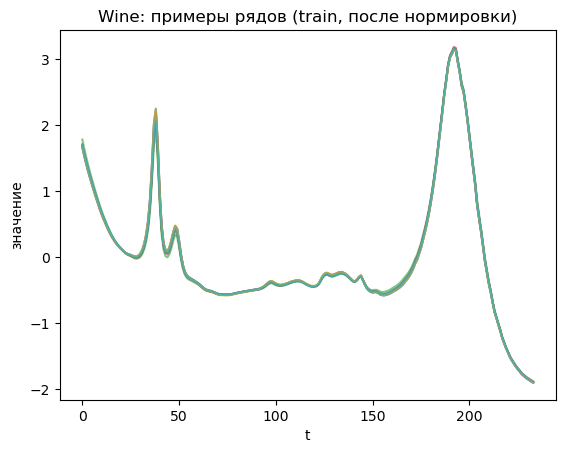

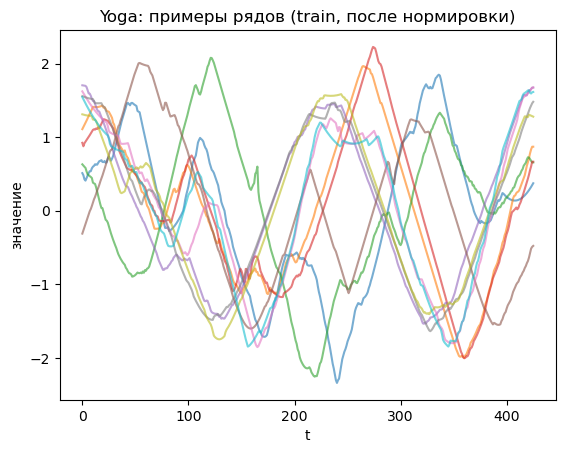

In [24]:
# –î–ª—è –Ω–∞–≥–ª—è–¥–Ω–æ—Å—Ç–∏ –Ω–∞—Ä–∏—Å—É–µ–º –ø–æ –Ω–µ—Å–∫–æ–ª—å–∫–æ —Ä—è–¥–æ–≤ –∫–∞–∂–¥–æ–≥–æ –∫–ª–∞—Å—Å–∞
rnd = np.random.RandomState(123)

for ds_name, (Xtr, ytr, _, _) in normed_sets.items():
    labels = np.unique(ytr)

    plt.figure()
    for c in labels:
        idxs = np.where(ytr == c)[0]
        # –Ω–µ –±–æ–ª–µ–µ 5 —Ä—è–¥–æ–≤ –Ω–∞ –∫–ª–∞—Å—Å
        if len(idxs) > 5:
            idxs = rnd.choice(idxs, size=5, replace=False)
        for i in idxs:
            plt.plot(Xtr[i], alpha=0.6)
    plt.title(f"{ds_name}: –ø—Ä–∏–º–µ—Ä—ã —Ä—è–¥–æ–≤ (train, –ø–æ—Å–ª–µ –Ω–æ—Ä–º–∏—Ä–æ–≤–∫–∏)")
    plt.xlabel("t")
    plt.ylabel("–∑–Ω–∞—á–µ–Ω–∏–µ")
    plt.show()


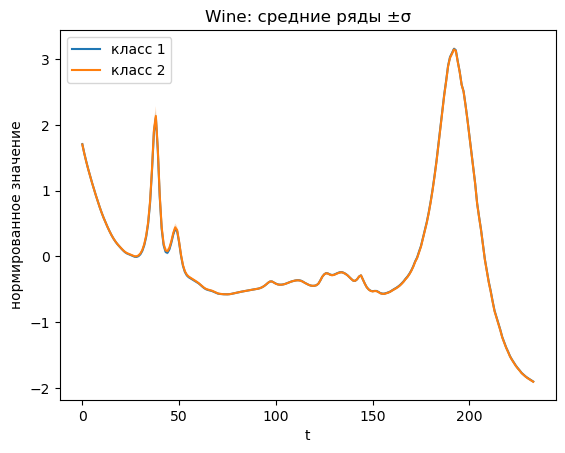

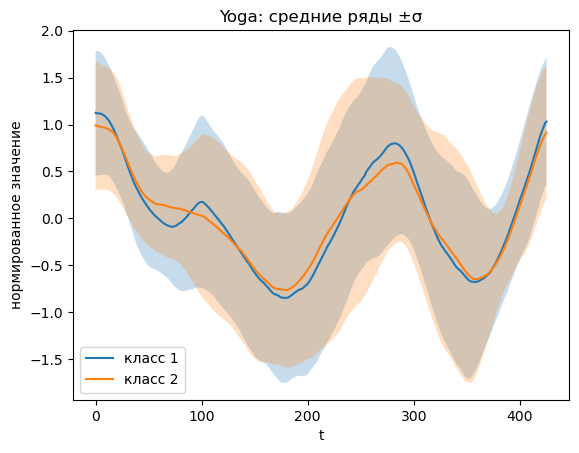

In [26]:
# –î–ª—è –∫–∞–∂–¥–æ–≥–æ –∫–ª–∞—Å—Å–∞ –ø–æ—Å–º–æ—Ç—Ä–∏–º —É—Å—Ä–µ–¥–Ω—ë–Ω–Ω—ã–π —Ä—è–¥ + —Ä–∞–∑–±—Ä–æ—Å (—Å–∏–≥–º–∞)
for ds_name, (Xtr, ytr, _, _) in normed_sets.items():
    t_axis = np.arange(Xtr.shape[1])
    plt.figure()

    for c in np.unique(ytr):
        group = Xtr[ytr == c]
        avg = group.mean(axis=0)
        spread = group.std(axis=0)
        plt.plot(t_axis, avg, label=f"–∫–ª–∞—Å—Å {c}", linewidth=1.5)
        plt.fill_between(t_axis, avg - spread, avg + spread, alpha=0.25)

    plt.title(f"{ds_name}: —Å—Ä–µ–¥–Ω–∏–µ —Ä—è–¥—ã ¬±œÉ")
    plt.xlabel("t"); plt.ylabel("–Ω–æ—Ä–º–∏—Ä–æ–≤–∞–Ω–Ω–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ")
    plt.legend()
    plt.show()


In [28]:
# –ò—Ç–æ–≥–æ–≤—ã–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã –∏ –º–∞—Ç—Ä–∏—Ü—ã –æ—à–∏–±–æ–∫
results_table = []
conf_mats = {}

# –ù–∞ –Ω–æ—Ä–º–∏—Ä–æ–≤–∞–Ω–Ω—ã—Ö —Ä—è–¥–∞—Ö –∑–∞–ø—É—Å—Ç–∏–º 1-NN (k=1, –µ–≤–∫–ª–∏–¥)
for ds_name, (Xtr, ytr, Xte, yte) in normed_sets.items():
    t0 = time.time()

    clf = KNeighborsClassifier(n_neighbors=1, metric="euclidean", n_jobs=-1)
    clf.fit(Xtr, ytr)
    preds = clf.predict(Xte)

    t1 = time.time()

    acc = accuracy_score(yte, preds)
    bacc = balanced_accuracy_score(yte, preds)
    cm = confusion_matrix(yte, preds)

    print(f"{ds_name}: 1-NN –Ω–∞ –Ω–æ—Ä–º. —Ä—è–¥–∞—Ö ‚Üí acc={acc:.3f}, bal_acc={bacc:.3f}, –≤—Ä–µ–º—è={t1-t0:.2f}c")
    display(pd.DataFrame(cm))

    results_table.append({
        "dataset": ds_name, "model": "1-NN (euclid)", 
        "accuracy": round(acc, 4),
        "balanced_accuracy": round(bacc, 4),
        "inference_sec": round(t1 - t0, 2)
    })
    conf_mats[(ds_name, "1-NN (euclid)")] = cm.tolist()


Wine: 1-NN –Ω–∞ –Ω–æ—Ä–º. —Ä—è–¥–∞—Ö ‚Üí acc=0.611, bal_acc=0.611, –≤—Ä–µ–º—è=0.06c


0   1
0  16  11
1  10  17

Yoga: 1-NN –Ω–∞ –Ω–æ—Ä–º. —Ä—è–¥–∞—Ö ‚Üí acc=0.830, bal_acc=0.828, –≤—Ä–µ–º—è=0.07c


0     1
0  1098   295
1   214  1393

In [27]:
# –î–ª—è –∫–∞–∂–¥–æ–≥–æ —Ä—è–¥–∞ –ø–æ—Å—á–∏—Ç–∞–µ–º –∫–æ–º–ø–∞–∫—Ç–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏
# (—Å—Ä–µ–¥–Ω–µ–µ, –¥–∏—Å–ø–µ—Ä—Å–∏—è, –º–∏–Ω–∏–º—É–º, –º–∞–∫—Å–∏–º—É–º, –∞—Å–∏–º–º–µ—Ç—Ä–∏—è, —ç–∫—Å—Ü–µ—Å—Å, —ç–Ω–µ—Ä–≥–∏—è –∏ —Ç.–¥.)
train_feats, test_feats = {}, {}

for ds_name, (Xtr, ytr, Xte, yte) in normed_sets.items():
    def extract_features(matrix):
        feats = []
        for seq in matrix:
            n = len(seq)
            mu, sd = seq.mean(), seq.std()
            z = (seq - mu) / (sd + 1e-12) if sd > 0 else np.zeros_like(seq)

            # –±–∞–∑–æ–≤—ã–µ –ø–æ–∫–∞–∑–∞—Ç–µ–ª–∏
            row = {
                "mean": mu, "std": sd,
                "min": float(seq.min()), "max": float(seq.max()),
                "median": float(np.median(seq)),
                "skew": float(np.mean(z**3)),
                "kurt": float(np.mean(z**4) - 3.0),
                "energy": float(np.mean(seq**2)),
                "zero_cross": int(np.sum(np.signbit(seq)[:-1] != np.signbit(seq)[1:]))
            }

            # –ª–∏–Ω–µ–π–Ω—ã–π —Ç—Ä–µ–Ω–¥
            t = np.arange(n)
            row["slope"] = float(np.polyfit(t, seq, 1)[0]) if n > 1 else 0.0

            # –∞–≤—Ç–æ–∫–æ—Ä—Ä–µ–ª—è—Ü–∏—è –Ω–∞ –ª–∞–≥–∞—Ö 1‚Äì5
            x0 = seq - mu
            var = (x0**2).sum()
            if var == 0:
                acf = np.zeros(5)
            else:
                corr = np.correlate(x0, x0, mode="full")
                mid = len(corr)//2
                acf = corr[mid+1:mid+6] / var
            for j in range(5):
                row[f"acf_{j+1}"] = float(acf[j])

            feats.append(row)
        return pd.DataFrame(feats)

    train_feats[ds_name] = extract_features(Xtr)
    test_feats[ds_name] = extract_features(Xte)

    print(f"{ds_name}: —Ñ–∏—á–µ–π={train_feats[ds_name].shape[1]}, —Ä–∞–∑–º–µ—Ä—ã TRAIN={train_feats[ds_name].shape}, TEST={test_feats[ds_name].shape}")
    display(train_feats[ds_name].head(3))


Wine: —Ñ–∏—á–µ–π=15, —Ä–∞–∑–º–µ—Ä—ã TRAIN=(57, 15), TEST=(54, 15)


mean  std       min       max    median      skew      kurt  \
0  1.138690e-17  1.0 -1.923014  3.126290 -0.342242  1.160558  1.640021   
1  1.897817e-18  1.0 -1.923412  3.111953 -0.333693  1.150415  1.603278   
2  1.328472e-17  1.0 -1.926721  3.106443 -0.331099  1.143505  1.588682   

   energy  zero_cross     slope     acf_1     acf_2     acf_3     acf_4  \
0     1.0           5 -0.001652  0.977450  0.942689  0.900128  0.853551   
1     1.0           5 -0.001643  0.977327  0.942255  0.899342  0.852514   
2     1.0           5 -0.001671  0.977258  0.942019  0.898917  0.851926   

      acf_5  
0  0.805004  
1  0.803883  
2  0.803173

Yoga: —Ñ–∏—á–µ–π=15, —Ä–∞–∑–º–µ—Ä—ã TRAIN=(300, 15), TEST=(3000, 15)


mean  std       min       max    median      skew      kurt  \
0  3.335881e-17  1.0 -2.147514  1.817730 -0.061847 -0.183745 -0.596899   
1  6.671763e-17  1.0 -2.173054  1.930468 -0.110055 -0.100188 -0.592161   
2 -1.667941e-17  1.0 -2.068631  1.535303  0.117642 -0.464057 -0.823073   

   energy  zero_cross     slope     acf_1     acf_2     acf_3     acf_4  \
0     1.0           6  0.001379  0.998973  0.996191  0.991801  0.985900   
1     1.0           6  0.000423  0.996713  0.991513  0.984419  0.975734   
2     1.0          10  0.000620  0.996613  0.991392  0.984429  0.975749   

      acf_5  
0  0.978570  
1  0.965292  
2  0.965462

In [29]:
# –¢–µ–ø–µ—Ä—å –ø–æ–ø—Ä–æ–±—É–µ–º Random Forest –Ω–∞ —Å–∫–æ–Ω—Å—Ç—Ä—É–∏—Ä–æ–≤–∞–Ω–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–∞—Ö
for ds_name, (Xtr, ytr, Xte, yte) in normed_sets.items():
    Xtr_f, Xte_f = train_feats[ds_name], test_feats[ds_name]

    # –±–∞–∑–æ–≤–∞—è –º–æ–¥–µ–ª—å RF
    rf_base = RandomForestClassifier(random_state=0, n_jobs=-1)

    # —Å–µ—Ç–∫–∞ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –¥–ª—è –ø–æ–¥–±–æ—Ä–∞ (–æ—á–µ–Ω—å –ø—Ä–æ—Å—Ç–∞—è)
    grid = {"n_estimators": [200], "max_depth": [None, 15]}
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

    search = GridSearchCV(rf_base, param_grid=grid, cv=cv, scoring="accuracy", n_jobs=-1)
    search.fit(Xtr_f, ytr)

    best_rf = search.best_estimator_
    preds = best_rf.predict(Xte_f)

    acc = accuracy_score(yte, preds)
    bacc = balanced_accuracy_score(yte, preds)
    cm = confusion_matrix(yte, preds)

    print(f"{ds_name}: RF –ø–æ —Ñ–∏—á–∞–º ‚Üí acc={acc:.3f}, bal_acc={bacc:.3f}, –ª—É—á—à–∏–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã={search.best_params_}")
    display(pd.DataFrame(cm))

    results_table.append({
        "dataset": ds_name, "model": "RF(features)",
        "accuracy": round(acc, 4),
        "balanced_accuracy": round(bacc, 4),
        "inference_sec": np.nan
    })
    conf_mats[(ds_name, "RF(features)")] = cm.tolist()


Wine: RF –ø–æ —Ñ–∏—á–∞–º ‚Üí acc=0.593, bal_acc=0.593, –ª—É—á—à–∏–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã={'max_depth': None, 'n_estimators': 200}


0   1
0  19   8
1  14  13

Yoga: RF –ø–æ —Ñ–∏—á–∞–º ‚Üí acc=0.783, bal_acc=0.779, –ª—É—á—à–∏–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã={'max_depth': None, 'n_estimators': 200}


0     1
0  1011   382
1   270  1337

In [30]:
# –§–∏–Ω–∞–ª—å–Ω–∞—è —Ç–∞–±–ª–∏—Ü–∞ —Å–æ –≤—Å–µ–º–∏ —ç–∫—Å–ø–µ—Ä–∏–º–µ–Ω—Ç–∞–º–∏
summary = (
    pd.DataFrame(results_table)
    .sort_values(["dataset", "accuracy"], ascending=[True, False])
    .reset_index(drop=True)
)

print("üèÅ –ò—Ç–æ–≥–æ–≤–∞—è —Å–≤–æ–¥–∫–∞:")
display(summary)


üèÅ –ò—Ç–æ–≥–æ–≤–∞—è —Å–≤–æ–¥–∫–∞:


dataset          model  accuracy  balanced_accuracy  inference_sec
0    Wine  1-NN (euclid)    0.6111             0.6111           0.06
1    Wine   RF(features)    0.5926             0.5926            NaN
2    Yoga  1-NN (euclid)    0.8303             0.8275           0.07
3    Yoga   RF(features)    0.7827             0.7789            NaN